In [1]:
import numpy as np
from numpy import linalg as LA
import os
import torch

In [2]:
def lr_train(invars):
   
    # Get ice velocity for nan filtering
    uit = invars[0]
    vit = invars[1]

    # Get dimensions for output arrays
    nt, ny, nx = np.shape(invars[0])
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)
    
    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices and unpack input list
                    uit_f, vit_f, uwt_f, vwt_f, icy_f = [var[true_mask,iy,ix] for var in invars]

                    # Convert to complex
                    it_c = uit_f + vit_f*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_f + vwt_f*1j # Complex 'today' wind vector
                    icy_c = icy_f + icy_f*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T

                    # Solve for model parameters
                    m = (LA.inv((G.conj().T @ G))) @ G.conj().T @ d

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

In [3]:
def lr_predict(invars, m):

    # Get ice velocity for nan filtering
    uit = invars[0]
    vit = invars[1]

    # Get dimensions for output arrays
    nt, ny, nx = np.shape(invars[0])
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    pred_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    
    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Filter inputs to valid indices
            uit_f, vit_f, uwt_f, vwt_f, icy_f = [var[:,iy,ix] for var in invars]

            # Convert to complex
            it_c = uit_f + vit_f*1j # Complex 'today' ice velocity vector       
            wt_c = uwt_f + vwt_f*1j # Complex 'today' wind vector
            icy_c = icy_f + 0*1j # Complex 'yesterday' ice concentration
            
            # Store true complex ice velocity vectors at valid points
            true_all[:, iy, ix] = it_c

            # Define gram matrix
            G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

            G[:,1] = wt_c # Complex wind, today
            G[:,2] = icy_c # Complex ice concentration, yesterday

            m_grid = m[:,iy,ix]

            # Calculate fit
            pred = G @ m_grid
            
            # Store predicted complex ice velocity vectors at valid points
            pred_all[:, iy, ix] = pred

        print(f'iy {iy} complete')
        
    return pred_all, true_all

In [4]:
# # Load train input variable file
# fnam = '/home/jbassham/jack/thesis-rough/data/lr-input/sh/20260107_164301/train_sh19922020_20260107_164301.npz'
# data = np.load(fnam)

# # Unpack input variables from .npz file
# x_train = data['x_train']
# y_train = data['y_train']

# print(np.shape(x_train))
# print(np.shape(y_train))

# uit_tr = y_train[:,0,:,:]
# vit_tr = y_train[:,0,:,:]


# uwt_tr = x_train[:,0,:,:]
# vwt_tr = x_train[:,1,:,:]
# icy_tr = x_train[:,2,:,:]

# # Pack input variables into list
# invars_train = [uit_tr, vit_tr, uwt_tr, vwt_tr, icy_tr]

In [9]:
# Load train input variable file
fnam = '/home/jbassham/jack/thesis-rough/data/cnn-input/sh/20260107_164301/train_sh19922020_20260107_164301.pt'

# Unpack input variables from .npz file
x_train, y_train, _ = torch.load(fnam)

x_train = x_train.numpy()
y_train = y_train.numpy()

x_train[x_train == 0] = np.nan
y_train[y_train == 0] = np.nan

print(np.shape(x_train))
print(np.shape(y_train))

uit_tr = y_train[:,0,:,:]
vit_tr = y_train[:,0,:,:]


uwt_tr = x_train[:,0,:,:]
vwt_tr = x_train[:,1,:,:]
icy_tr = x_train[:,2,:,:]

# Pack input variables into list
invars_train = [uit_tr, vit_tr, uwt_tr, vwt_tr, icy_tr]

/tmp/ipykernel_3347732/2423770722.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train, _ = torch.load(fnam)


(9131, 3, 81, 522)
(9131, 2, 81, 522)


In [10]:
# # Load train input variable file
# fnam = '/home/jbassham/jack/old-thesis/data/sh/inputs_v6/inputs_normalized_sh_1992_2020.npz'
# data = np.load(fnam)



# # Unpack input variables from .npz file
# uit_tr = data['uitn'][:9130,:,:]
# vit_tr = data['vitn'][:9130,:,:]

# print(np.shape(uit_tr))

# uwt_tr = data['uwtn'][:9130,:,:]
# vwt_tr = data['vwtn'][:9130,:,:]
# icy_tr = data['icyn'][:9130,:,:]

# print(np.shape(uwt_tr))

# # Pack input variables into list
# invars_train = [uit_tr, vit_tr, uwt_tr, vwt_tr, icy_tr]

In [11]:
# Train linear regression
m, fit_train, true_train = lr_train(invars_train)

print("All Training Points Complete")

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

In [12]:
# # Load test input variable file
# fnam = '/home/jbassham/jack/thesis-rough/data/lr-input/sh/20260107_164301/test_sh19922020_20260107_164301.npz'
# data = np.load(fnam)

# # Unpack input variables from .npz file
# x_train = data['x_test']
# y_train = data['y_test']

# uit_te = y_train[:,0,:,:]
# vit_te = y_train[:,0,:,:]


# uwt_te = x_train[:,0,:,:]
# vwt_te = x_train[:,1,:,:]
# icy_te = x_train[:,2,:,:]

# # Pack input variables into list
# invars_test = [uit_te, vit_te, uwt_te, vwt_te, icy_te]

In [14]:
# Load test input variable file
fnam = '/home/jbassham/jack/thesis-rough/data/cnn-input/sh/20260107_164301/test_sh19922020_20260107_164301.pt'

# Unpack input variables from .npz file
x_test, y_test, _ = torch.load(fnam)

x_test[x_test == 0] = np.nan
y_test[y_test == 0] = np.nan

x_test = x_test.numpy()
y_test = y_test.numpy()

uit_te = y_train[:,0,:,:]
vit_te = y_train[:,0,:,:]


uwt_te = x_train[:,0,:,:]
vwt_te = x_train[:,1,:,:]
icy_te = x_train[:,2,:,:]

# Pack input variables into list
invars_test = [uit_te, vit_te, uwt_te, vwt_te, icy_te]

/tmp/ipykernel_3347732/1936958600.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_test, y_test, _ = torch.load(fnam)


In [15]:
# # Load test input variable file
# fnam = '/home/jbassham/jack/old-thesis/data/sh/inputs_v6/inputs_normalized_sh_1992_2020.npz'
# data = np.load(fnam)



# # Unpack input variables from .npz file
# uit_te = data['uitn'][9131:,:,:]
# vit_te = data['vitn'][9131:,:,:]

# print(np.shape(uit_te))

# uwt_te = data['uwtn'][9131:,:,:]
# vwt_te = data['vwtn'][9131:,:,:]
# icy_te = data['icyn'][9131:,:,:]

# print(np.shape(uwt_te))

# # Pack input variables into list
# invars_test = [uit_te, vit_te, uwt_te, vwt_te, icy_te]

In [16]:
# Test linear regression
pred_test, true_test = lr_predict(invars_test, m)

print("All testing Points Complete")

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

In [17]:
# # Save output
# fnam = f'lr_train_{HEM}_{START_YEAR}_{END_YEAR}_{VERSION}.npz'

# np.savez(os.path.join(PATH_DEST, fnam), m = m, fit_train = fit_train, true_train = true_train)

# print(f"LR training outputs saved at: \n {PATH_DEST}/{fnam}")

In [18]:
# # Save output
# fnam = f'lr_pred_{HEM}_{START_YEAR}_{END_YEAR}_{VERSION}.npz'

# np.savez(os.path.join(PATH_DEST, fnam), pred_test = pred_test, true_test = true_test)

# print(f"LR testing outputs saved at: \n {PATH_DEST}/{fnam}")

In [19]:
# Plot / Verify outputs

import matplotlib.pyplot as plt

In [20]:
## FOR PLOTTING 

def skill(fit, true):
    
    skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
    # Check where true variance really small!
    
    return skill

def return_plot_skill(fit, true, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    # Calculate skill of complex output (the ice velocity vector)
    skill_z = skill(fit, true)
    # NOTE: Variance of complex input returned as Var(z)=E[(z−E[z])**2
    # so a real number is returned that represents the spread in both u and v components of the vector
    
    skill_u = skill(np.real(fit), np.real(true))
    skill_v = skill(np.imag(fit), np.imag(true))
    
    data = [skill_z, skill_u, skill_v]
    nd = len(data)
    titles = ['vector', 'u', 'v']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*3), constrained_layout=True)
    
    for i in range(3):
        pcm = axs[i].pcolormesh(data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Skill')
        axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
        
    fig.suptitle(f'Skill {model}')
    plt.show()
    
    return skill_z, skill_u, skill_v

/tmp/ipykernel_3347732/3514016755.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_3347732/3514016755.py:5: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


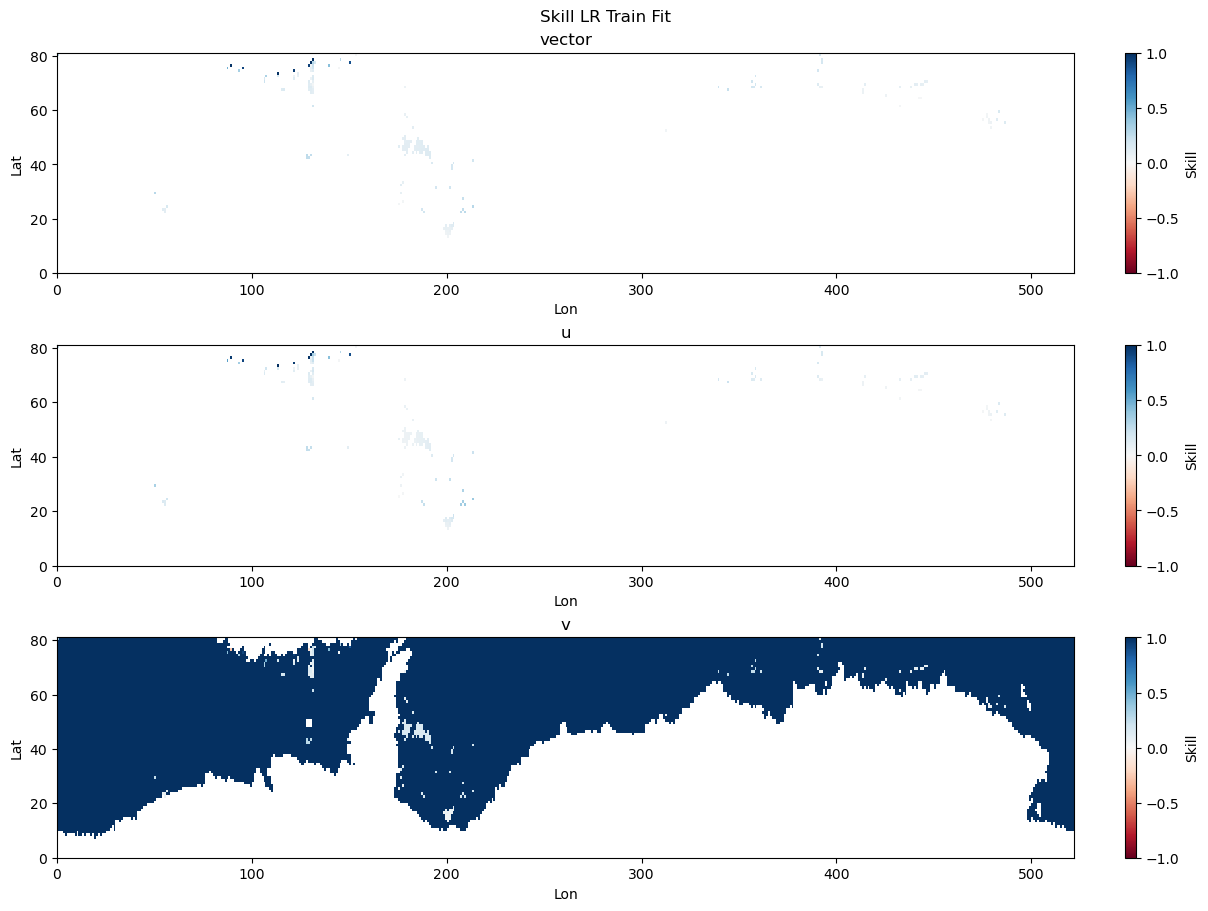

In [21]:
_, _, _ = return_plot_skill(fit_train, true_train, f'LR Train Fit')

/tmp/ipykernel_3347732/3514016755.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_3347732/3514016755.py:5: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


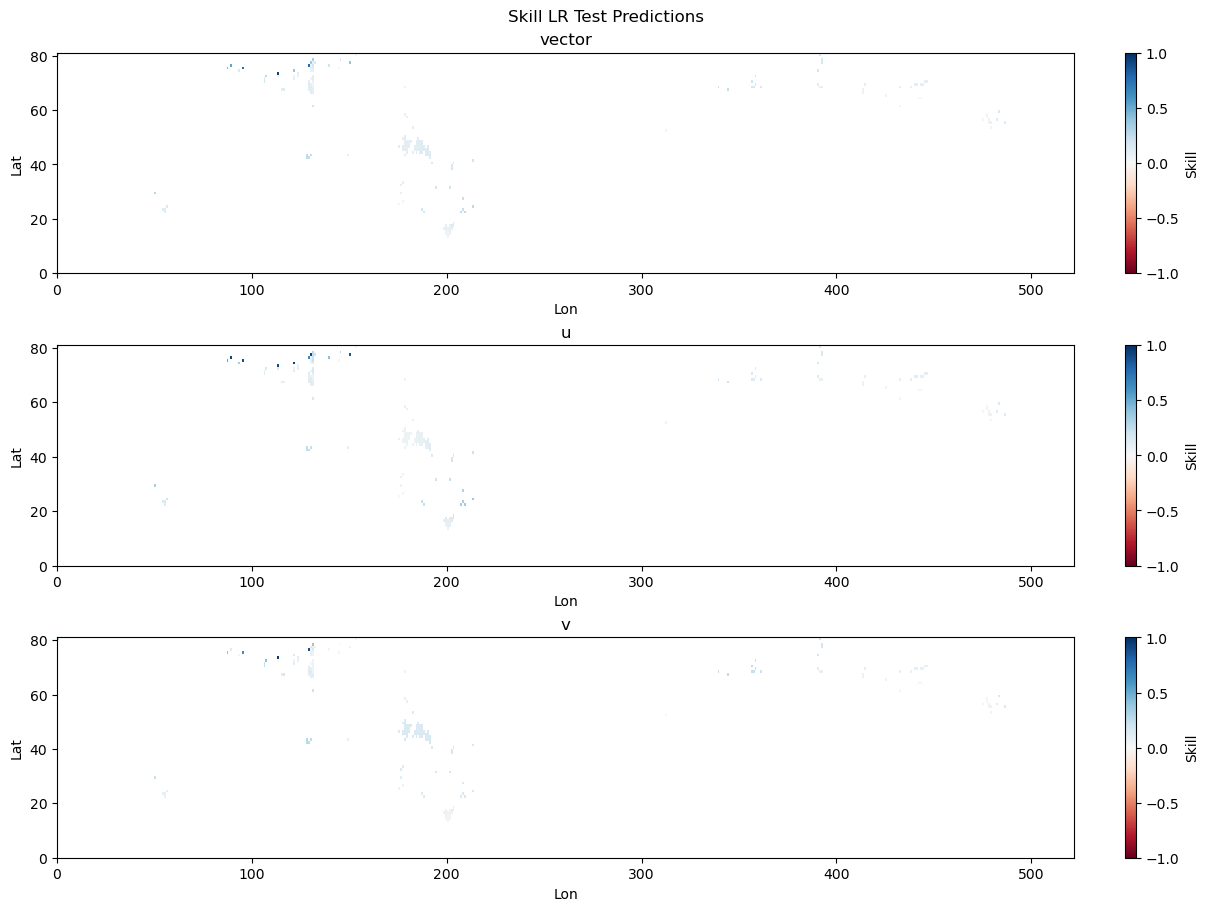

In [22]:
_, _, _ = return_plot_skill(pred_test, true_test, f'LR Test Predictions')